In [1]:
# Importing all the necessary libraries needed throughout the study
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from scipy.signal import welch
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from joblib import Parallel, delayed

In [ ]:
eeg_data = raw_eeg.pick_types(eeg=True)
eeg_values, times = eeg_data[:]
eeg_train = pd.DataFrame(eeg_values.T, columns = eeg_data.info['ch_names'])
eeg_train

In [ ]:
# Preprocessing the data of 10 subjects of each class pairs by taking the mental imagery parts and extracting the band powers
# Class pairs: both fists - both feet, left fist - right fist, left fisr - both feet, right fist - both feet
# The dataset for each subject is seperated into 14 runs (the runs of 4,6,8,10,12,14 are where the motor imagery happens)
# The events are T0, T1 and T2 where our focus is T1 and T2 since the tasks are performed with these two
# T1: left fist in runs 4,8,12 / both fists in runs 6,10,14
# T2: right fist in runs 4,8,12 / both feet in runs 6,10,14
subjects = list(range(1,110))
processed_subject_dfs = []

for subject in subjects:
    tmin, tmax = 1., 2.

    # Both Fists - Both Feet
    runs = [6, 10, 14]
    raw = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in eegbci.load_data(subject, runs)]
    raw_file = mne.concatenate_raws(raw)
    events, event_id = events_from_annotations(raw_file)
    picks = pick_types(raw_file.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

    event_id = dict(hands=2, feet=3)
    epochs = Epochs(raw_file, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True, verbose=False)
    epochs_both_hand_both_feet = epochs.get_data() * 1e6
    labels_both_hand_both_feet = np.where(epochs.events[:, -1] - 2 == 0, 'both hands', 'both feet')

    # Left Fist - Right Fist
    runs = [4, 8, 12]
    raw = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in eegbci.load_data(subject, runs)]
    raw_file = mne.concatenate_raws(raw)
    events, event_id = events_from_annotations(raw_file)
    picks = pick_types(raw_file.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

    event_id = dict(left=2, right=3)
    epochs = Epochs(raw_file, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True, verbose=False)
    epochs_left_right = epochs.get_data() * 1e6
    labels_left_right = np.where(epochs.events[:, -1] - 2 == 0, 'left hand', 'right hand')

    # Left Fist - Both Feet
    runs = [4, 8, 12]
    raw = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in eegbci.load_data(subject, runs)]
    raw_file = mne.concatenate_raws(raw)
    events, event_id = events_from_annotations(raw_file)
    picks = pick_types(raw_file.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    event_id = dict(left=2)
    epochs = Epochs(raw_file, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True, verbose=False)
    epochs_left = epochs.get_data() * 1e6
    labels_left = ['left hand'] * epochs_left.shape[0]

    runs = [6, 10, 14]
    raw = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in eegbci.load_data(subject, runs)]
    raw_file = mne.concatenate_raws(raw)
    events, event_id = events_from_annotations(raw_file)
    event_id = dict(feet=3)
    epochs = Epochs(raw_file, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True, verbose=False)
    epochs_feet = epochs.get_data() * 1e6
    labels_feet = ['both feet'] * epochs_feet.shape[0]

    epochs_left_hand_both_feet = np.concatenate((epochs_left, epochs_feet), axis=0)
    labels_left_hand_both_feet = np.array(labels_left + labels_feet)

    # Right Fist - Both Feet
    runs = [4, 8, 12]
    raw = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in eegbci.load_data(subject, runs)]
    raw_file = mne.concatenate_raws(raw)
    events, event_id = events_from_annotations(raw_file)
    picks = pick_types(raw_file.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
    event_id = dict(right=3)
    epochs = Epochs(raw_file, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True, verbose=False)
    epochs_right = epochs.get_data() * 1e6
    labels_right = ['right hand'] * epochs_right.shape[0]

    runs = [6, 10, 14]
    raw = [mne.io.read_raw_edf(f, preload=True, verbose=False) for f in eegbci.load_data(subject, runs)]
    raw_file = mne.concatenate_raws(raw)
    events, event_id = events_from_annotations(raw_file)
    event_id = dict(feet=3)
    epochs = Epochs(raw_file, events, event_id, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True, verbose=False)
    epochs_feet = epochs.get_data() * 1e6
    labels_feet = ['both feet'] * epochs_feet.shape[0]

    epochs_right_hand_both_feet = np.concatenate((epochs_right, epochs_feet), axis=0)
    labels_right_hand_both_feet = np.array(labels_right + labels_feet)

    def band_power(epoch_data):
        frequency_bands = {
            'DELTA': [0.5, 3.5],
            'THETA': [4, 7],
            'ALPHA': [8, 13],
            'BETA': [13, 25],
            'GAMMA': [25, 48]
        }
        fs = 160
        frequencies, psd = signal.welch(epoch_data, fs, nperseg=1024, axis=-1)
        band_powers = {}
        for band, (fmin, fmax) in frequency_bands.items():
            freq_indices = np.where((frequencies >= fmin) & (frequencies <= fmax))[0]
            if freq_indices.size > 0:
                power = np.trapz(psd[:, :, freq_indices], frequencies[freq_indices], axis=-1)
                band_powers[band] = power
        band_powers_df = pd.DataFrame()
        for band, power_matrix in band_powers.items():
            for ch in range(power_matrix.shape[1]):
                band_powers_df[f"{band}_ch{ch}"] = power_matrix[:, ch]
        return band_powers_df

    def band_power_extraction(epoch_data, epoch_labels):
        band_powers_df = band_power(epoch_data)
        band_powers_df["label"] = epoch_labels
        return band_powers_df

    processed_subject_dfs.append(band_power_extraction(epochs_both_hand_both_feet, labels_both_hand_both_feet))
    processed_subject_dfs.append(band_power_extraction(epochs_left_right, labels_left_right))
    processed_subject_dfs.append(band_power_extraction(epochs_left_hand_both_feet, labels_left_hand_both_feet))
    processed_subject_dfs.append(band_power_extraction(epochs_right_hand_both_feet, labels_right_hand_both_feet))

In [ ]:
# accuracies without feature selection for each subject, band power, class pair and classifier
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

accuracies = []

for i in range(len(processed_subject_dfs)):
    subject_id = (i // 4) + 1
    X = processed_subject_dfs[i].drop("label", axis=1)
    y = processed_subject_dfs[i]["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    for band_power in ['ALPHA', 'BETA', 'DELTA', 'GAMMA', 'THETA']:
        band_power_columns = [col for col in X.columns if band_power in col]
        X_train_band = X_train[band_power_columns]
        X_test_band = X_test[band_power_columns]

        for model_name, model in models.items():
            model.fit(X_train_band, y_train)
            y_pred = model.predict(X_test_band)
            accuracy = accuracy_score(y_test, y_pred)

            class_pairs = sorted(set(y_test.unique()))

            accuracies.append({
                    "Subject ID": subject_id,
                    "Band Power": band_power,
                    "Class Pairs": class_pairs,
                    "Model": model_name,
                    "Accuracy": round(accuracy,2)
                })

accuracy_df = pd.DataFrame(accuracies)
accuracy_df

,Subject ID,Band Power,Class Pairs,Model,Accuracy
0,1,ALPHA,"both feet,both hands",Logistic Regression,0.56
1,1,ALPHA,"both feet,both hands",Decision Tree,0.44
2,1,ALPHA,"both feet,both hands",Random Forest,0.67
3,1,ALPHA,"both feet,both hands",SVC,0.56
4,1,ALPHA,"both feet,both hands",KNN,0.44
...,...,...,...,...,...
13075,109,THETA,"both feet,right hand",Decision Tree,0.67
13076,109,THETA,"both feet,right hand",Random Forest,0.56
13077,109,THETA,"both feet,right hand",SVC,0.33
13078,109,THETA,"both feet,right hand",KNN,0.44


In [ ]:
# accuracies with kbest - anova
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

accuracies = []

for i in range(len(processed_subject_dfs)):
    subject_id = (i // 4) + 1
    X = processed_subject_dfs[i].drop("label", axis=1)
    y = processed_subject_dfs[i]["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for band_power in ['ALPHA', 'BETA', 'DELTA', 'GAMMA', 'THETA']:
        band_power_columns = [col for col in X.columns if band_power in col]
        X_train_band = X_train[band_power_columns]
        X_test_band = X_test[band_power_columns]

        class_pairs = sorted(set(y_test.unique()))

        for model_name, model in models.items():
            best_accuracy = 0
            best_k = 0

            for k in range(1, X_train_band.shape[1] + 1):
                kbest = SelectKBest(f_classif, k=k)
                X_train_kbest = kbest.fit_transform(X_train_band, y_train)
                X_test_kbest = kbest.transform(X_test_band)

                model.fit(X_train_kbest, y_train)
                y_pred = model.predict(X_test_kbest)
                accuracy = accuracy_score(y_test, y_pred)

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_k = k

            accuracies.append({
                "Subject ID": subject_id,
                "Band Power": band_power,
                "Class Pairs": class_pairs,
                "Model": model_name + " - kbest - anova",
                "Best k": best_k,
                "Accuracy": round(best_accuracy, 2)
            })

accuracies_with_kbest_anova = pd.DataFrame(accuracies)
accuracies_with_kbest_anova

,Subject ID,Band Power,Class Pairs,Model,Best k,Accuracy
0,1,ALPHA,"both feet, both hands",Logistic Regression - kbest - anova,5.0,0.89
1,1,ALPHA,"both feet, both hands",Decision Tree - kbest - anova,1.0,0.78
2,1,ALPHA,"both feet, both hands",Random Forest - kbest - anova,1.0,0.78
3,1,ALPHA,"both feet, both hands",SVC - kbest - anova,9.0,0.67
4,1,ALPHA,"both feet, both hands",KNN - kbest - anova,9.0,0.78
...,...,...,...,...,...,...
13075,109,THETA,"both feet,right hand",Decision Tree - kbest - anova,3.0,0.67
13076,109,THETA,"both feet,right hand",Random Forest - kbest - anova,37.0,0.89
13077,109,THETA,"both feet,right hand",SVC - kbest - anova,24.0,0.67
13078,109,THETA,"both feet,right hand",KNN - kbest - anova,24.0,0.67


In [ ]:
# accuracies with variance treshold
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

accuracies = []

for i in range(len(processed_subject_dfs)):
    subject_id = (i // 4) + 1
    X = processed_subject_dfs[i].drop("label", axis=1)
    y = processed_subject_dfs[i]["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for band_power in ['ALPHA', 'BETA', 'DELTA', 'GAMMA', 'THETA']:
        band_power_columns = [col for col in X.columns if band_power in col]
        X_train_band = X_train[band_power_columns]
        X_test_band = X_test[band_power_columns]

        class_pairs = sorted(set(y_test.unique()))

        for model_name, model in models.items():
            best_accuracy = 0
            best_threshold = 0

            for threshold in [0.01, 0.1, 0.2, 0.5, 1.0]:
                variance_threshold = VarianceThreshold(threshold=threshold)
                X_train_vt = variance_threshold.fit_transform(X_train_band)
                X_test_vt = variance_threshold.transform(X_test_band)

                model.fit(X_train_vt, y_train)
                y_pred = model.predict(X_test_vt)
                accuracy = accuracy_score(y_test, y_pred)

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_threshold = threshold

            accuracies.append({
                "Subject ID": subject_id,
                "Band Power": band_power,
                "Class Pairs": class_pairs,
                "Model": model_name + " - variance threshold",
                "Best threshold": round(best_threshold, 2),
                "Accuracy": round(best_accuracy, 2)
            })

accuracies_with_variance_threshold = pd.DataFrame(accuracies)
accuracies_with_variance_threshold

,Subject ID,Band Power,Class Pairs,Model,Best threshold,Accuracy
0,1,ALPHA,"both feet,both hands",Logistic Regression - variance threshold,0.01,0.56
1,1,ALPHA,"both feet,both hands",Decision Tree - variance threshold,0.10,0.56
2,1,ALPHA,"both feet,both hands",Random Forest - variance threshold,0.01,0.67
3,1,ALPHA,"both feet,both hands",SVC - variance threshold,0.01,0.56
4,1,ALPHA,"both feet,both hands",KNN - variance threshold,0.01,0.44
...,...,...,...,...,...,...
13075,109,THETA,"both feet,right hand",Decision Tree - variance threshold,0.01,0.67
13076,109,THETA,"both feet,right hand",Random Forest - variance threshold,0.01,0.89
13077,109,THETA,"both feet,right hand",SVC - variance threshold,0.01,0.33
13078,109,THETA,"both feet,right hand",KNN - variance threshold,0.01,0.44


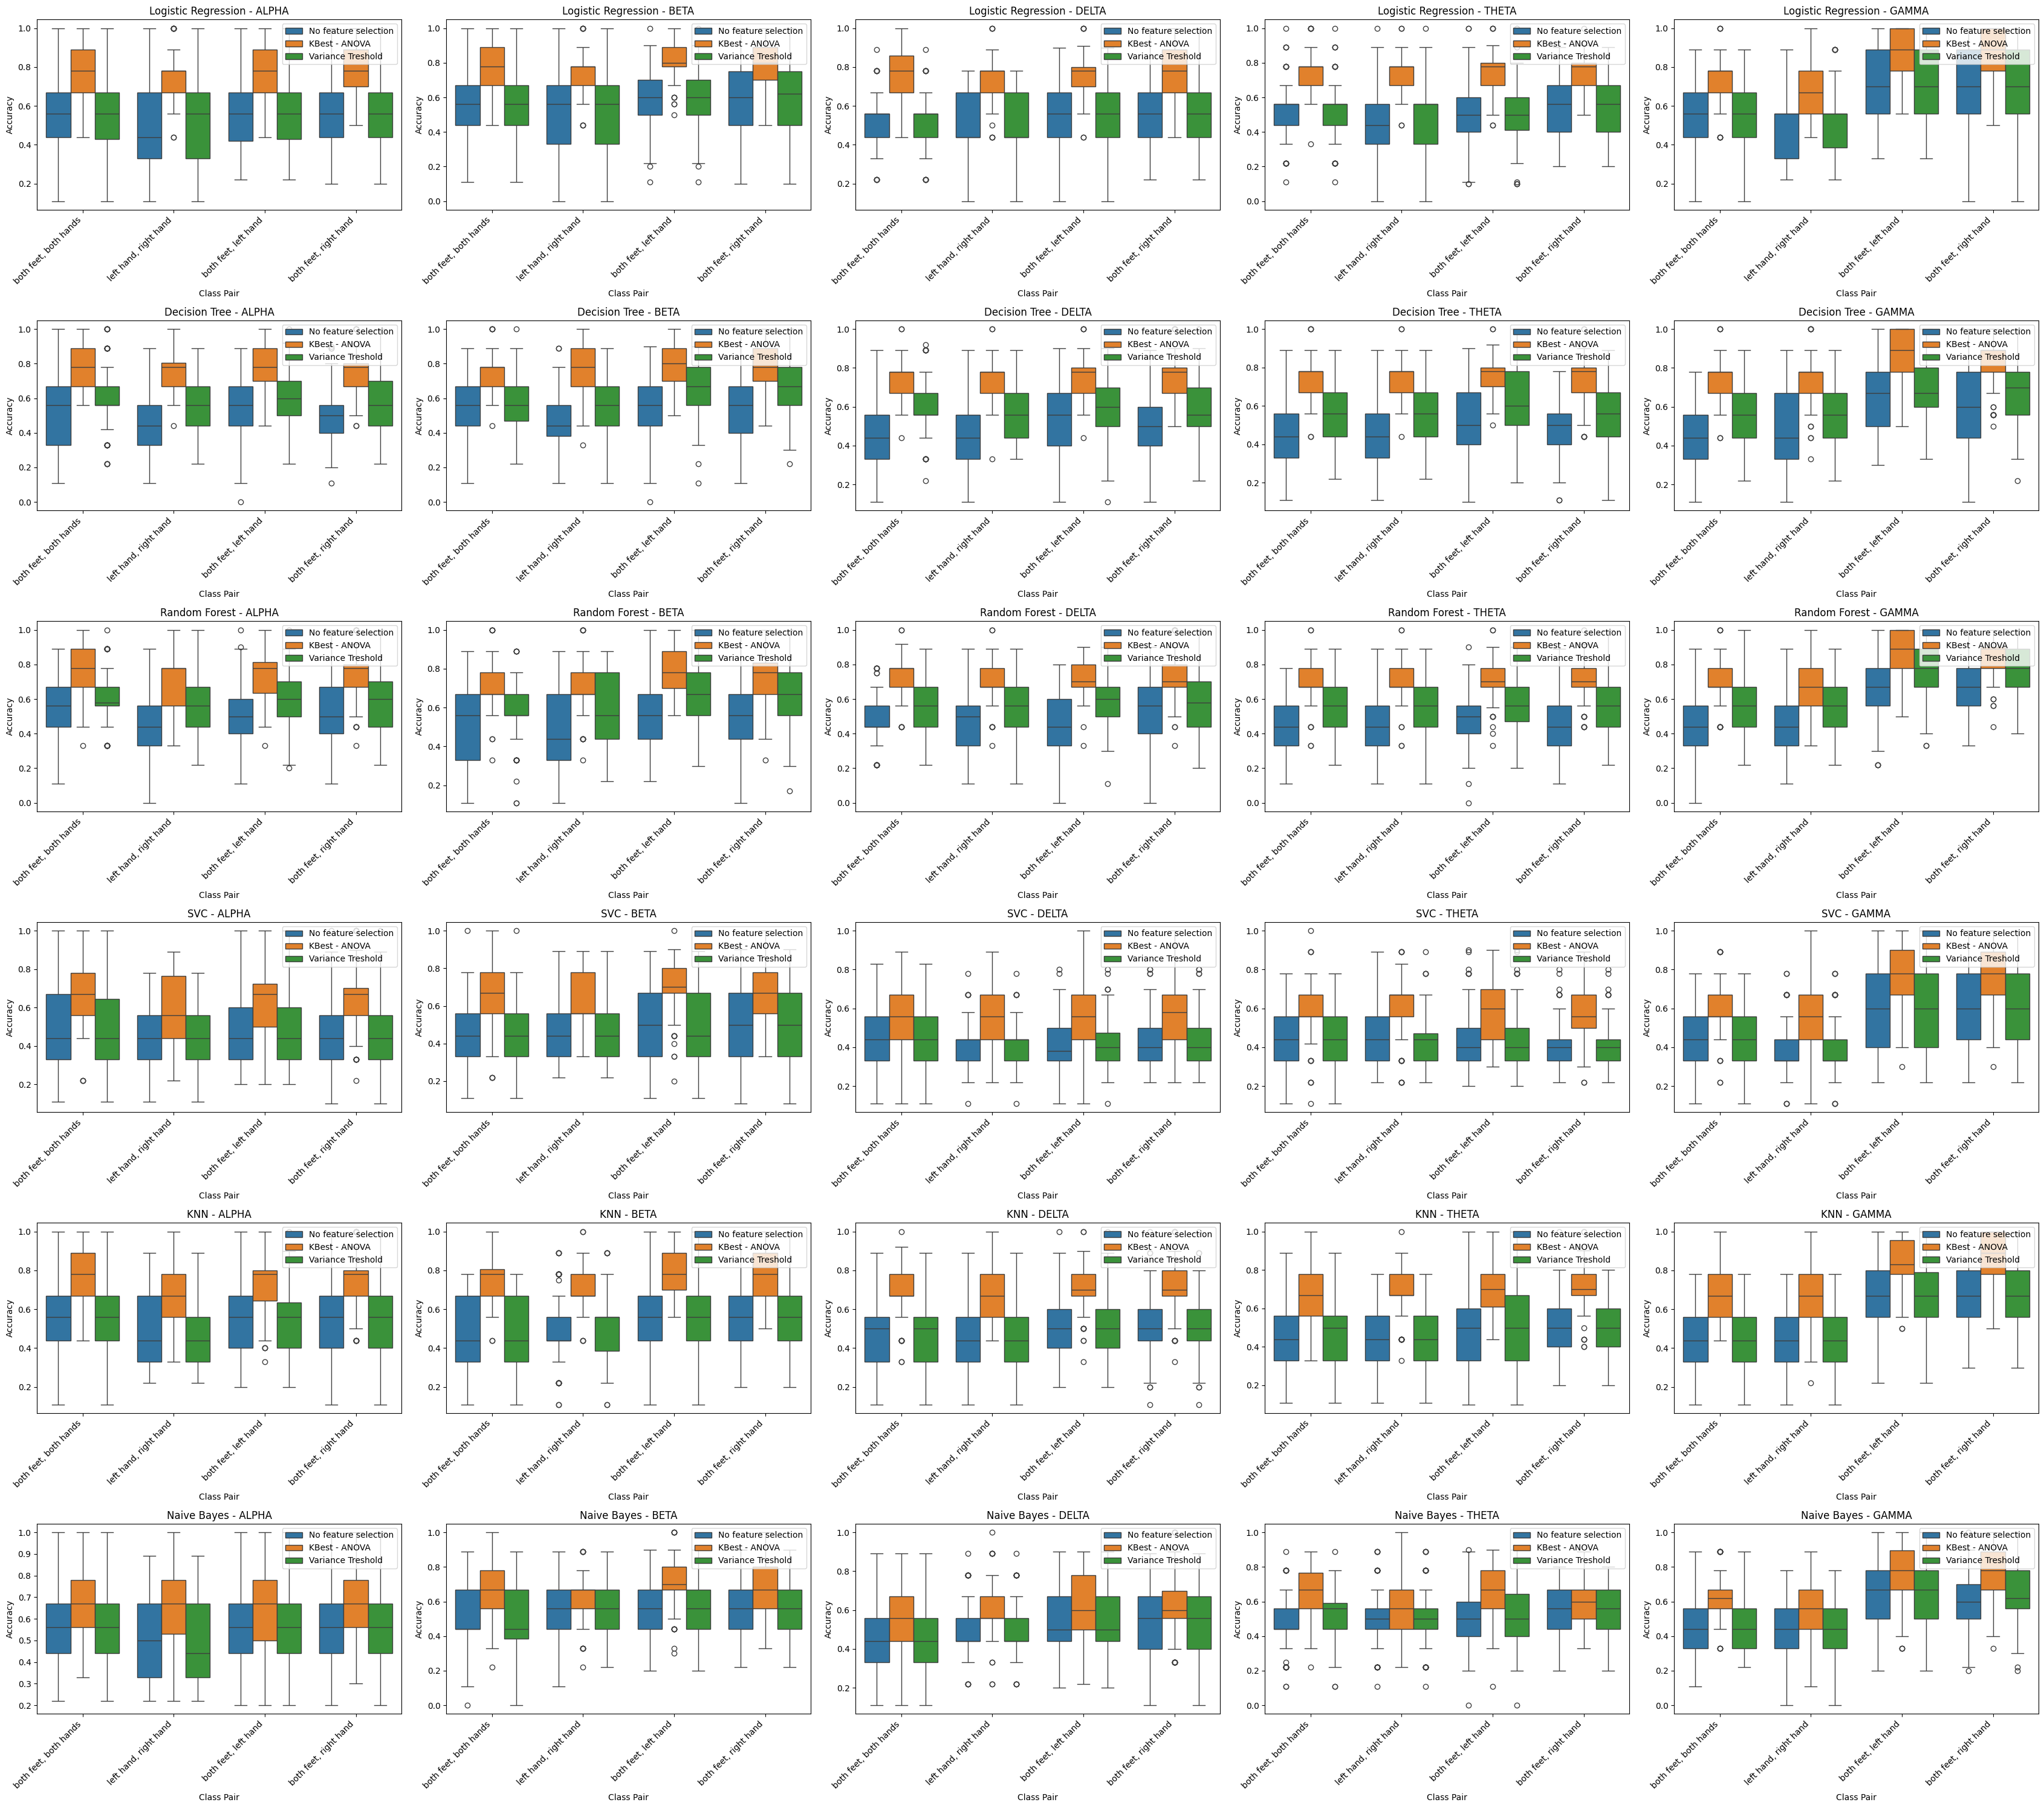

In [33]:
# Visualization of the accuracies to compare the feature selection methods
all_accuracies = pd.concat([accuracy_df, accuracies_with_kbest_anova.drop(columns="Best k"), accuracies_with_variance_threshold], axis=0)
all_accuracies["legend"] = all_accuracies["Model"].apply(lambda x: "KBest - ANOVA" if "anova" in x else ("Variance Treshold" if "variance" in x else "No feature selection"))
no_selection = all_accuracies[all_accuracies["legend"] == "No feature selection"]
kbest = all_accuracies[all_accuracies["legend"] == "KBest - ANOVA"]
variance_treshold = all_accuracies[all_accuracies["legend"] == "Variance Treshold"]
all_accuracies = pd.concat([no_selection, kbest, variance_treshold], axis=0, ignore_index=True)
all_accuracies["Class Pairs"] = all_accuracies["Class Pairs"].str.replace(r"\s*,\s*", ", ", regex=True)


band_powers = ["ALPHA", "BETA", "DELTA", "THETA", "GAMMA"]
models = ["Logistic Regression", "Decision Tree", "Random Forest", "SVC", "KNN", "Naive Bayes"]

fig, axes = plt.subplots(6, 5, figsize=(34, 30))
axes = axes.flatten()

subplot_id = 0
for model in models:
    classifier_result = all_accuracies[all_accuracies["Model"].str.contains(model)]
    for band_power in band_powers:
        ax = axes[subplot_id]
        subset = classifier_result[classifier_result["Band Power"] == band_power]
        
        sns.boxplot(x="Class Pairs", y="Accuracy", hue="legend", data=subset, ax=ax)

        ax.set_title(f"{model} - {band_power}")
        ax.set_xlabel("Class Pair")
        ax.set_ylabel("Accuracy")

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.legend(loc="upper right")

        subplot_id += 1

plt.tight_layout()
plt.show()